In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import numpy as np
#import plotly.express as px

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency, fisher_exact



from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold,GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

from scipy.stats import boxcox
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier



# input_path
input_path = "D:/Final-Project/ff.csv"
data = pd.read_csv(input_path)

# Dataset information
print(f"Dataset Shape: {data.shape}")
print("Dataset Info:")
data.info()
#IMBALANCE OR NOT
data['TARGET'].value_counts()

Dataset Shape: (1413701, 53)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413701 entries, 0 to 1413700
Data columns (total 53 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1413701 non-null  int64  
 1   TARGET                        1413701 non-null  int64  
 2   NAME_CONTRACT_TYPE_x          1413701 non-null  int64  
 3   CODE_GENDER                   1413701 non-null  int64  
 4   FLAG_OWN_CAR                  1413701 non-null  int64  
 5   FLAG_OWN_REALTY               1413701 non-null  int64  
 6   AMT_INCOME_TOTAL              1413701 non-null  float64
 7   AMT_CREDIT_x                  1413701 non-null  float64
 8   AMT_ANNUITY_x                 1413701 non-null  float64
 9   NAME_INCOME_TYPE              1413701 non-null  int64  
 10  FLAG_WORK_PHONE               1413701 non-null  float64
 11  FLAG_CONT_MOBILE              1413701 non-null

TARGET
0    1291341
1     122360
Name: count, dtype: int64

In [5]:
# Function to check if outliers exist in each column using the IQR method
def check_outliers_presence(df):
    outlier_presence = {}
    
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        if len(outliers) > 0:
            outlier_presence[col] = "Yes, outlier is present in this column"
        else:
            outlier_presence[col] = "No outlier present"
    
    return outlier_presence

# Checking outliers presence in the simulated dataset data
outlier_check_results = check_outliers_presence(data)
outlier_check_results


{'SK_ID_CURR': 'No outlier present',
 'TARGET': 'Yes, outlier is present in this column',
 'NAME_CONTRACT_TYPE_x': 'Yes, outlier is present in this column',
 'CODE_GENDER': 'No outlier present',
 'FLAG_OWN_CAR': 'No outlier present',
 'FLAG_OWN_REALTY': 'No outlier present',
 'AMT_INCOME_TOTAL': 'Yes, outlier is present in this column',
 'AMT_CREDIT_x': 'Yes, outlier is present in this column',
 'AMT_ANNUITY_x': 'Yes, outlier is present in this column',
 'NAME_INCOME_TYPE': 'No outlier present',
 'FLAG_WORK_PHONE': 'No outlier present',
 'FLAG_CONT_MOBILE': 'No outlier present',
 'FLAG_EMAIL': 'No outlier present',
 'OCCUPATION_TYPE': 'Yes, outlier is present in this column',
 'REGION_RATING_CLIENT': 'No outlier present',
 'WEEKDAY_APPR_PROCESS_START_x': 'No outlier present',
 'ORGANIZATION_TYPE': 'No outlier present',
 'EXT_SOURCE_2': 'No outlier present',
 'EXT_SOURCE_3': 'No outlier present',
 'FLOORSMAX_AVG': 'No outlier present',
 'HOUSETYPE_MODE': 'Yes, outlier is present in this

In [7]:
# Extracting columns with outliers into a list
columns_with_outliers = [col for col, result in outlier_check_results.items() if "Yes" in result]

# Displaying the list of columns with outliers
print(columns_with_outliers)

['TARGET', 'NAME_CONTRACT_TYPE_x', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'CODE_REJECT_REASON', 'NAME_PORTFOLIO', 'CHANNEL_TYPE', 'TENURE', 'COS_HOUR']


In [11]:
# Selecting the specified columns from the dataset
specified_columns = [
    'TARGET', 'NAME_CONTRACT_TYPE_x', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x',
    'AMT_ANNUITY_x', 'OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE',
    'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS',
    'DAYS_DECISION', 'CODE_REJECT_REASON', 'NAME_PORTFOLIO', 'CHANNEL_TYPE',
    'TENURE', 'COS_HOUR'
]

# Extracting unique values for each column
unique_values = {col: data[col].unique() for col in specified_columns}
unique_values


{'TARGET': array([1, 0], dtype=int64),
 'NAME_CONTRACT_TYPE_x': array([0, 1], dtype=int64),
 'AMT_INCOME_TOTAL': array([202500. , 270000. ,  67500. , ...,  96768. , 546250.5, 113062.5]),
 'AMT_CREDIT_x': array([ 406597.5, 1293502.5,  135000. , ...,  181989. ,  743863.5,
        1391130. ]),
 'AMT_ANNUITY_x': array([24700.5, 35698.5,  6750. , ..., 56304. , 56857.5, 22207.5]),
 'OCCUPATION_TYPE': array([ 8,  3,  0, 10,  4, 14,  1, 12, 11, 16,  2,  6, 17,  9, 13, 15,  7,
         5], dtype=int64),
 'HOUSETYPE_MODE': array([0, 2, 1], dtype=int64),
 'EMERGENCYSTATE_MODE': array([0, 1], dtype=int64),
 'FLAG_LAST_APPL_PER_CONTRACT': array([1, 0], dtype=int64),
 'NAME_CASH_LOAN_PURPOSE': array([23, 24, 16, 17,  6, 20,  8,  5,  9, 14,  7, 21,  3,  0, 10, 13, 18,
        22,  4,  1, 11,  2, 12, 15, 19], dtype=int64),
 'NAME_CONTRACT_STATUS': array([0, 1, 2, 3], dtype=int64),
 'DAYS_DECISION': array([-6.060e+02, -7.460e+02, -8.280e+02, ..., -2.055e+03, -2.014e+03,
        -1.000e+00]),
 'CODE_REJ

In [13]:
# Function to cap outliers using the IQR method
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap the outliers
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

# Specified columns with outliers
columns_to_correct = ['COS_HOUR', 'TENURE', 'DAYS_DECISION', 
                      'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x']

# Correcting the outliers in the dataset
data_corrected = cap_outliers(data, columns_to_correct)

# Displaying the corrected dataset summary
data_corrected[columns_to_correct].describe()


,COS_HOUR,TENURE,DAYS_DECISION,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x
count,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06
mean,-7.039629e-01,4.037633e+00,-8.282318e+02,1.685344e+05,5.536908e+05,2.569019e+04
std,3.258036e-01,1.765156e+00,7.238395e+02,7.401780e+04,3.302385e+05,1.155929e+04
min,-1.000000e+00,4.219178e-01,-2.606000e+03,2.565000e+04,4.500000e+04,1.615500e+03
25%,-9.659258e-01,2.854795e+00,-1.205000e+03,1.125000e+05,2.700000e+05,1.682100e+04
50%,-8.660254e-01,4.476712e+00,-5.710000e+02,1.575000e+05,4.991715e+05,2.459250e+04
75%,-5.000000e-01,4.476712e+00,-2.710000e+02,2.070000e+05,7.602255e+05,3.287700e+04
max,1.988887e-01,6.909589e+00,-1.000000e+00,3.487500e+05,1.495564e+06,5.696100e+04


In [15]:
data_corrected.shape

(1413701, 53)

In [19]:
data_corrected.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,NAME_INCOME_TYPE,...,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_TERMINATION,AGE,TENURE,ID_AGE,PHONE_CHANGE_AGE,SOCIAL_CIRCLE_RATIO,SIN_HOUR,COS_HOUR
0,100002,1,0,1,0,1,202500.0,406597.5,24700.5,6,...,-825.0,-534.0,-494.0,25.920548,1.745205,5.808219,3.106849,0.666667,0.500000,-0.866025
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,3,...,-825.0,-534.0,-494.0,45.931507,3.254795,0.797260,2.268493,1.000000,0.258819,-0.965926
2,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,3,...,-825.0,-534.0,-494.0,45.931507,3.254795,0.797260,2.268493,1.000000,0.258819,-0.965926
3,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,3,...,-825.0,-534.0,-494.0,45.931507,3.254795,0.797260,2.268493,1.000000,0.258819,-0.965926
4,100004,0,1,1,1,1,67500.0,135000.0,6750.0,6,...,-825.0,-534.0,-494.0,52.180822,0.616438,6.934247,2.232877,0.000000,0.707107,-0.707107


In [21]:
# Function to check if outliers exist in each column using the IQR method
def check_outliers_presence_2(df):
    outlier_presence_2 = {}
    
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_2 = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        if len(outliers_2) > 0:
            outlier_presence_2[col] = "Yes, outlier is present in this column"
        else:
            outlier_presence_2[col] = "No outlier present"
    
    return outlier_presence_2

# Checking outliers presence in the simulated dataset data
outlier_check_results_2 = check_outliers_presence_2(data)
outlier_check_results_2


{'SK_ID_CURR': 'No outlier present',
 'TARGET': 'Yes, outlier is present in this column',
 'NAME_CONTRACT_TYPE_x': 'Yes, outlier is present in this column',
 'CODE_GENDER': 'No outlier present',
 'FLAG_OWN_CAR': 'No outlier present',
 'FLAG_OWN_REALTY': 'No outlier present',
 'AMT_INCOME_TOTAL': 'No outlier present',
 'AMT_CREDIT_x': 'No outlier present',
 'AMT_ANNUITY_x': 'No outlier present',
 'NAME_INCOME_TYPE': 'No outlier present',
 'FLAG_WORK_PHONE': 'No outlier present',
 'FLAG_CONT_MOBILE': 'No outlier present',
 'FLAG_EMAIL': 'No outlier present',
 'OCCUPATION_TYPE': 'Yes, outlier is present in this column',
 'REGION_RATING_CLIENT': 'No outlier present',
 'WEEKDAY_APPR_PROCESS_START_x': 'No outlier present',
 'ORGANIZATION_TYPE': 'No outlier present',
 'EXT_SOURCE_2': 'No outlier present',
 'EXT_SOURCE_3': 'No outlier present',
 'FLOORSMAX_AVG': 'No outlier present',
 'HOUSETYPE_MODE': 'Yes, outlier is present in this column',
 'EMERGENCYSTATE_MODE': 'Yes, outlier is present i

In [26]:
data_corrected.isnull().sum()

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE_x            0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
AMT_INCOME_TOTAL                0
AMT_CREDIT_x                    0
AMT_ANNUITY_x                   0
NAME_INCOME_TYPE                0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
REGION_RATING_CLIENT            0
WEEKDAY_APPR_PROCESS_START_x    0
ORGANIZATION_TYPE               0
EXT_SOURCE_2                    0
EXT_SOURCE_3                    0
FLOORSMAX_AVG                   0
HOUSETYPE_MODE                  0
EMERGENCYSTATE_MODE             0
FLAG_DOCUMENT_3                 0
AMT_REQ_CREDIT_BUREAU_DAY       0
AMT_REQ_CREDIT_BUREAU_WEEK      0
AMT_REQ_CREDIT_BUREAU_MON       0
AMT_REQ_CREDIT_BUREAU_QRT       0
AMT_REQ_CREDIT_BUREAU_YEAR      0
SK_ID_PREV                      0
FLAG_LAST_APPL

In [30]:
data_corrected.duplicated().sum()

0

# From this i conclude there is no null values, duplicate values and outliers present in my dataset

In [35]:
data_keep = data_corrected.copy()

In [37]:
# Save the corrected DataFrame to a CSV file
data_keep.to_csv("data_keep.csv", index=False)

print("The file has been saved as 'data_keep.csv'")

The file has been saved as 'data_keep.csv'


In [39]:
# 1. Total number of credit requests (sum of all time periods)
data_corrected['TOTAL_CREDIT_REQUESTS'] = (data_corrected['AMT_REQ_CREDIT_BUREAU_DAY'] +
                                             data_corrected['AMT_REQ_CREDIT_BUREAU_WEEK'] +
                                             data_corrected['AMT_REQ_CREDIT_BUREAU_MON'] +
                                             data_corrected['AMT_REQ_CREDIT_BUREAU_QRT'] +
                                             data_corrected['AMT_REQ_CREDIT_BUREAU_YEAR'])

# 2. Average number of credit requests across the different periods
data_corrected['AVG_CREDIT_REQUESTS'] = data_corrected[['AMT_REQ_CREDIT_BUREAU_DAY',
                                                        'AMT_REQ_CREDIT_BUREAU_WEEK',
                                                        'AMT_REQ_CREDIT_BUREAU_MON',
                                                        'AMT_REQ_CREDIT_BUREAU_QRT',
                                                        'AMT_REQ_CREDIT_BUREAU_YEAR']].mean(axis=1)

# Display the first few rows of the modified DataFrame
data_corrected[['TOTAL_CREDIT_REQUESTS', 'AVG_CREDIT_REQUESTS']].head()


,TOTAL_CREDIT_REQUESTS,AVG_CREDIT_REQUESTS
0,1.0,0.2
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [47]:
data_corrected.shape

(1413701, 55)

In [49]:
# List of columns to drop
columns_to_drop = [
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 
    'AMT_REQ_CREDIT_BUREAU_YEAR','SK_ID_PREV','PHONE_CHANGE_AGE'
]

# Drop the columns inplace in the data_corrected DataFrame
data_corrected.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows to verify the columns have been dropped
data_corrected.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,NAME_INCOME_TYPE,...,DAYS_LAST_DUE,DAYS_TERMINATION,AGE,TENURE,ID_AGE,SOCIAL_CIRCLE_RATIO,SIN_HOUR,COS_HOUR,TOTAL_CREDIT_REQUESTS,AVG_CREDIT_REQUESTS
0,100002,1,0,1,0,1,202500.0,406597.5,24700.5,6,...,-534.0,-494.0,25.920548,1.745205,5.808219,0.666667,0.500000,-0.866025,1.0,0.2
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,3,...,-534.0,-494.0,45.931507,3.254795,0.797260,1.000000,0.258819,-0.965926,0.0,0.0
2,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,3,...,-534.0,-494.0,45.931507,3.254795,0.797260,1.000000,0.258819,-0.965926,0.0,0.0
3,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,3,...,-534.0,-494.0,45.931507,3.254795,0.797260,1.000000,0.258819,-0.965926,0.0,0.0
4,100004,0,1,1,1,1,67500.0,135000.0,6750.0,6,...,-534.0,-494.0,52.180822,0.616438,6.934247,0.000000,0.707107,-0.707107,0.0,0.0


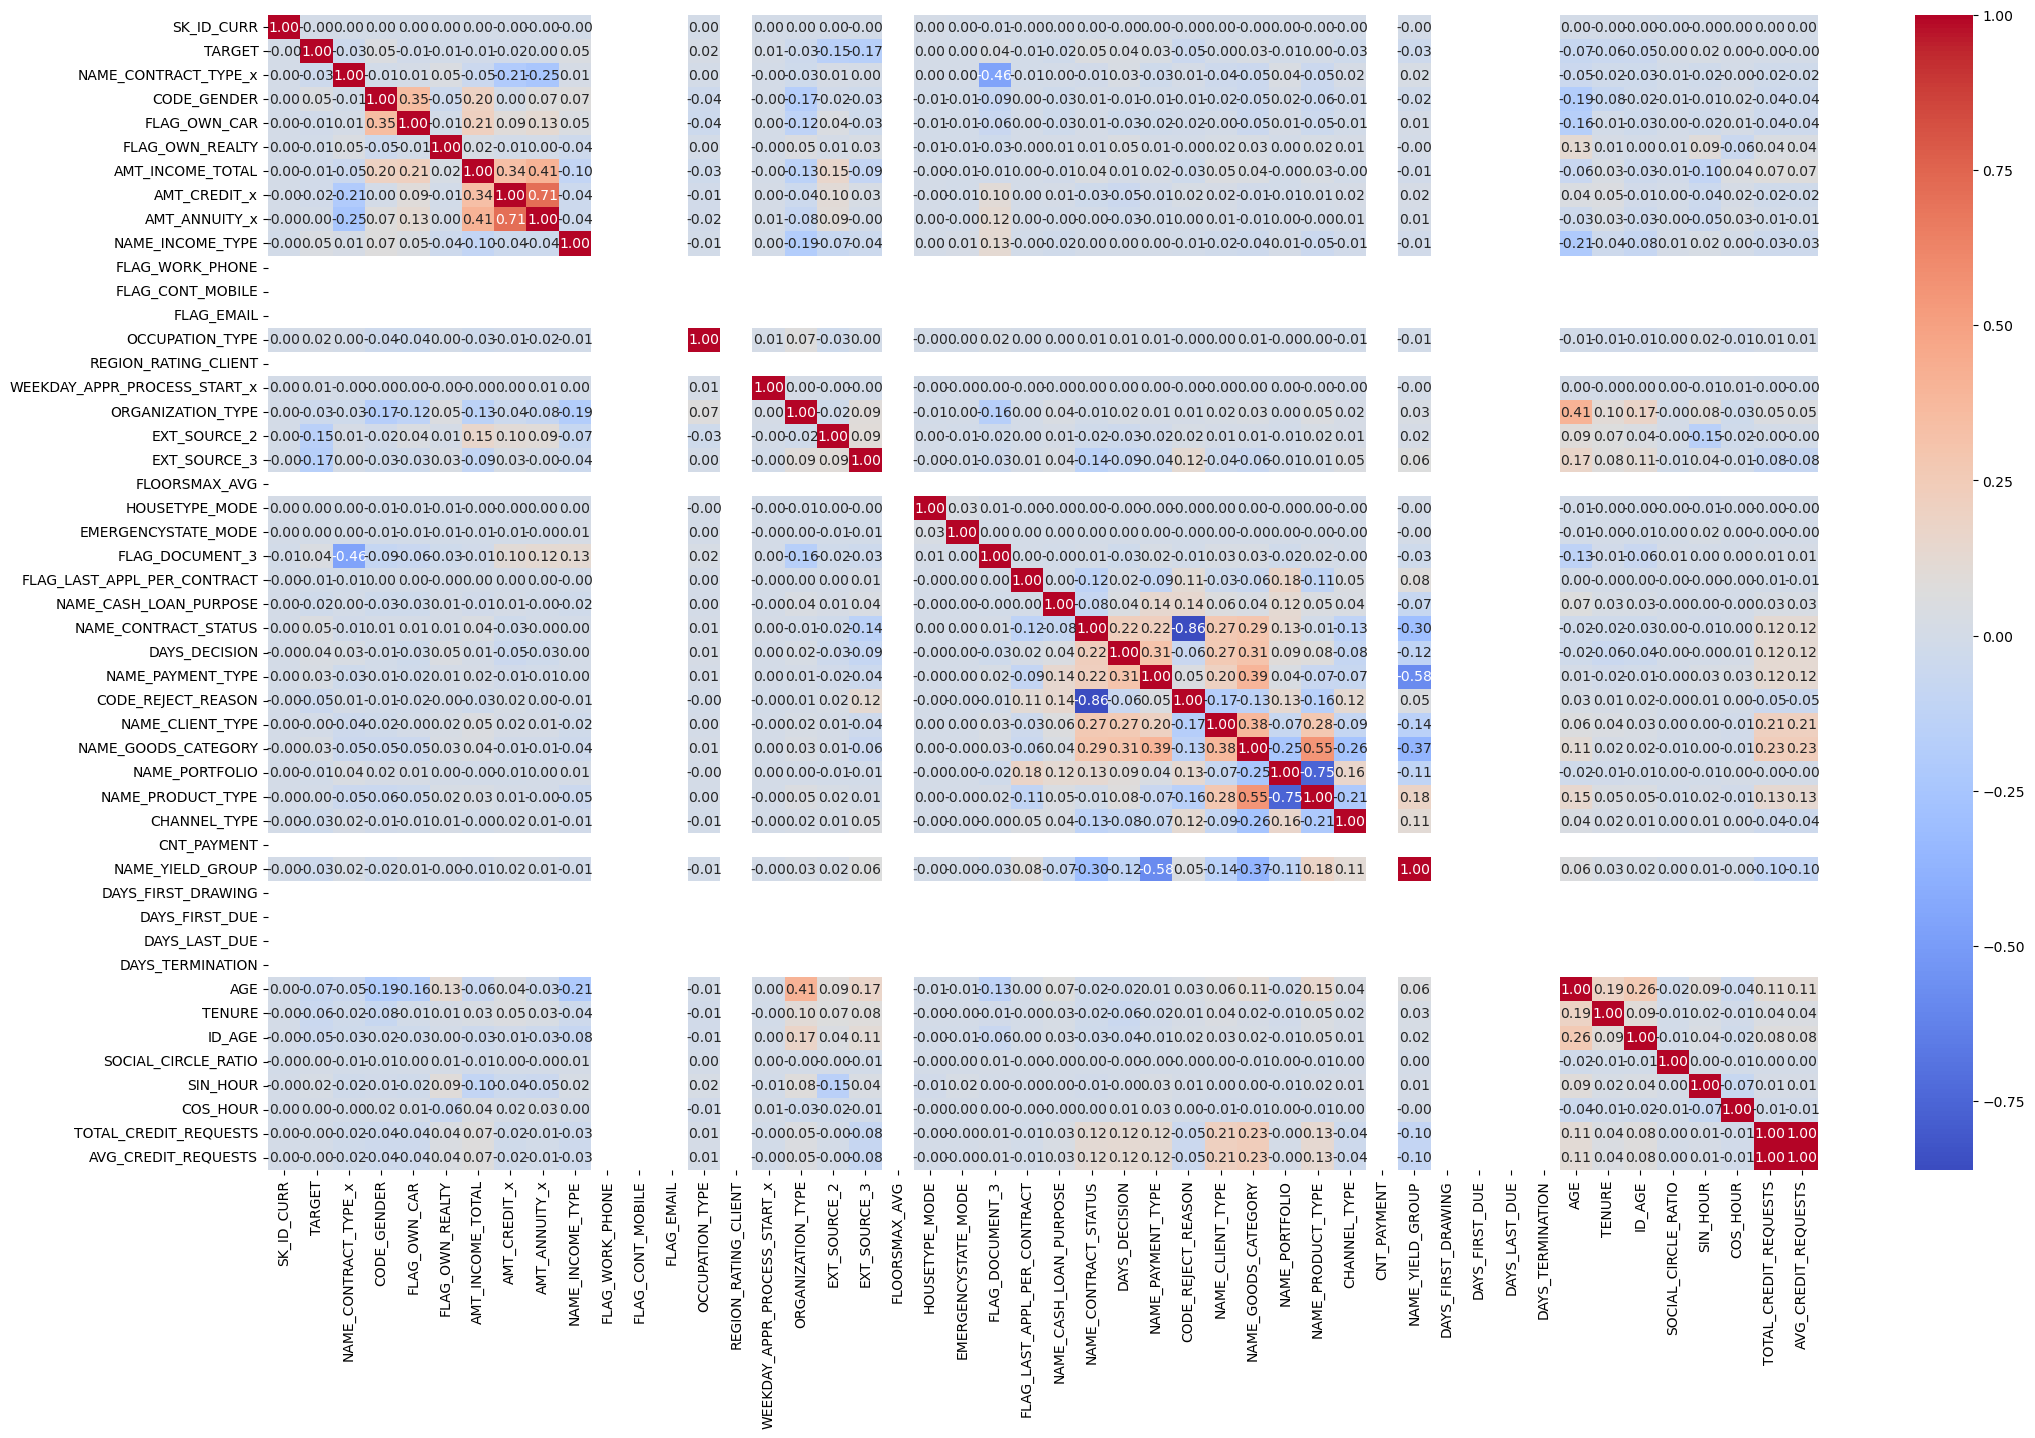

In [53]:


# Compute the correlation matrix
data_1 = data_corrected.corr()

# Create the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(data_1, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [55]:
# List of columns to drop
columns_to_drop = [
    'AGE', 'NAME_CLIENT_TYPE', 
    'NAME_GOODS_CATEGORY', 'NAME_CONTRACT_STATUS', 
    'AMT_CREDIT_x','NAME_YIELD_GROUP','DAYS_DECISION','SIN_HOUR','COS_HOUR'
]

# Drop the columns inplace in the data_corrected DataFrame
data_corrected.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows to verify the columns have been dropped
data_corrected.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_ANNUITY_x,NAME_INCOME_TYPE,FLAG_WORK_PHONE,...,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_TERMINATION,TENURE,ID_AGE,SOCIAL_CIRCLE_RATIO,TOTAL_CREDIT_REQUESTS,AVG_CREDIT_REQUESTS
0,100002,1,0,1,0,1,202500.0,24700.5,6,0.0,...,12.0,365243.0,-825.0,-534.0,-494.0,1.745205,5.808219,0.666667,1.0,0.2
1,100003,0,0,0,0,0,270000.0,35698.5,3,0.0,...,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0,0.0
2,100003,0,0,0,0,0,270000.0,35698.5,3,0.0,...,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0,0.0
3,100003,0,0,0,0,0,270000.0,35698.5,3,0.0,...,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0,0.0
4,100004,0,1,1,1,1,67500.0,6750.0,6,0.0,...,12.0,365243.0,-825.0,-534.0,-494.0,0.616438,6.934247,0.000000,0.0,0.0


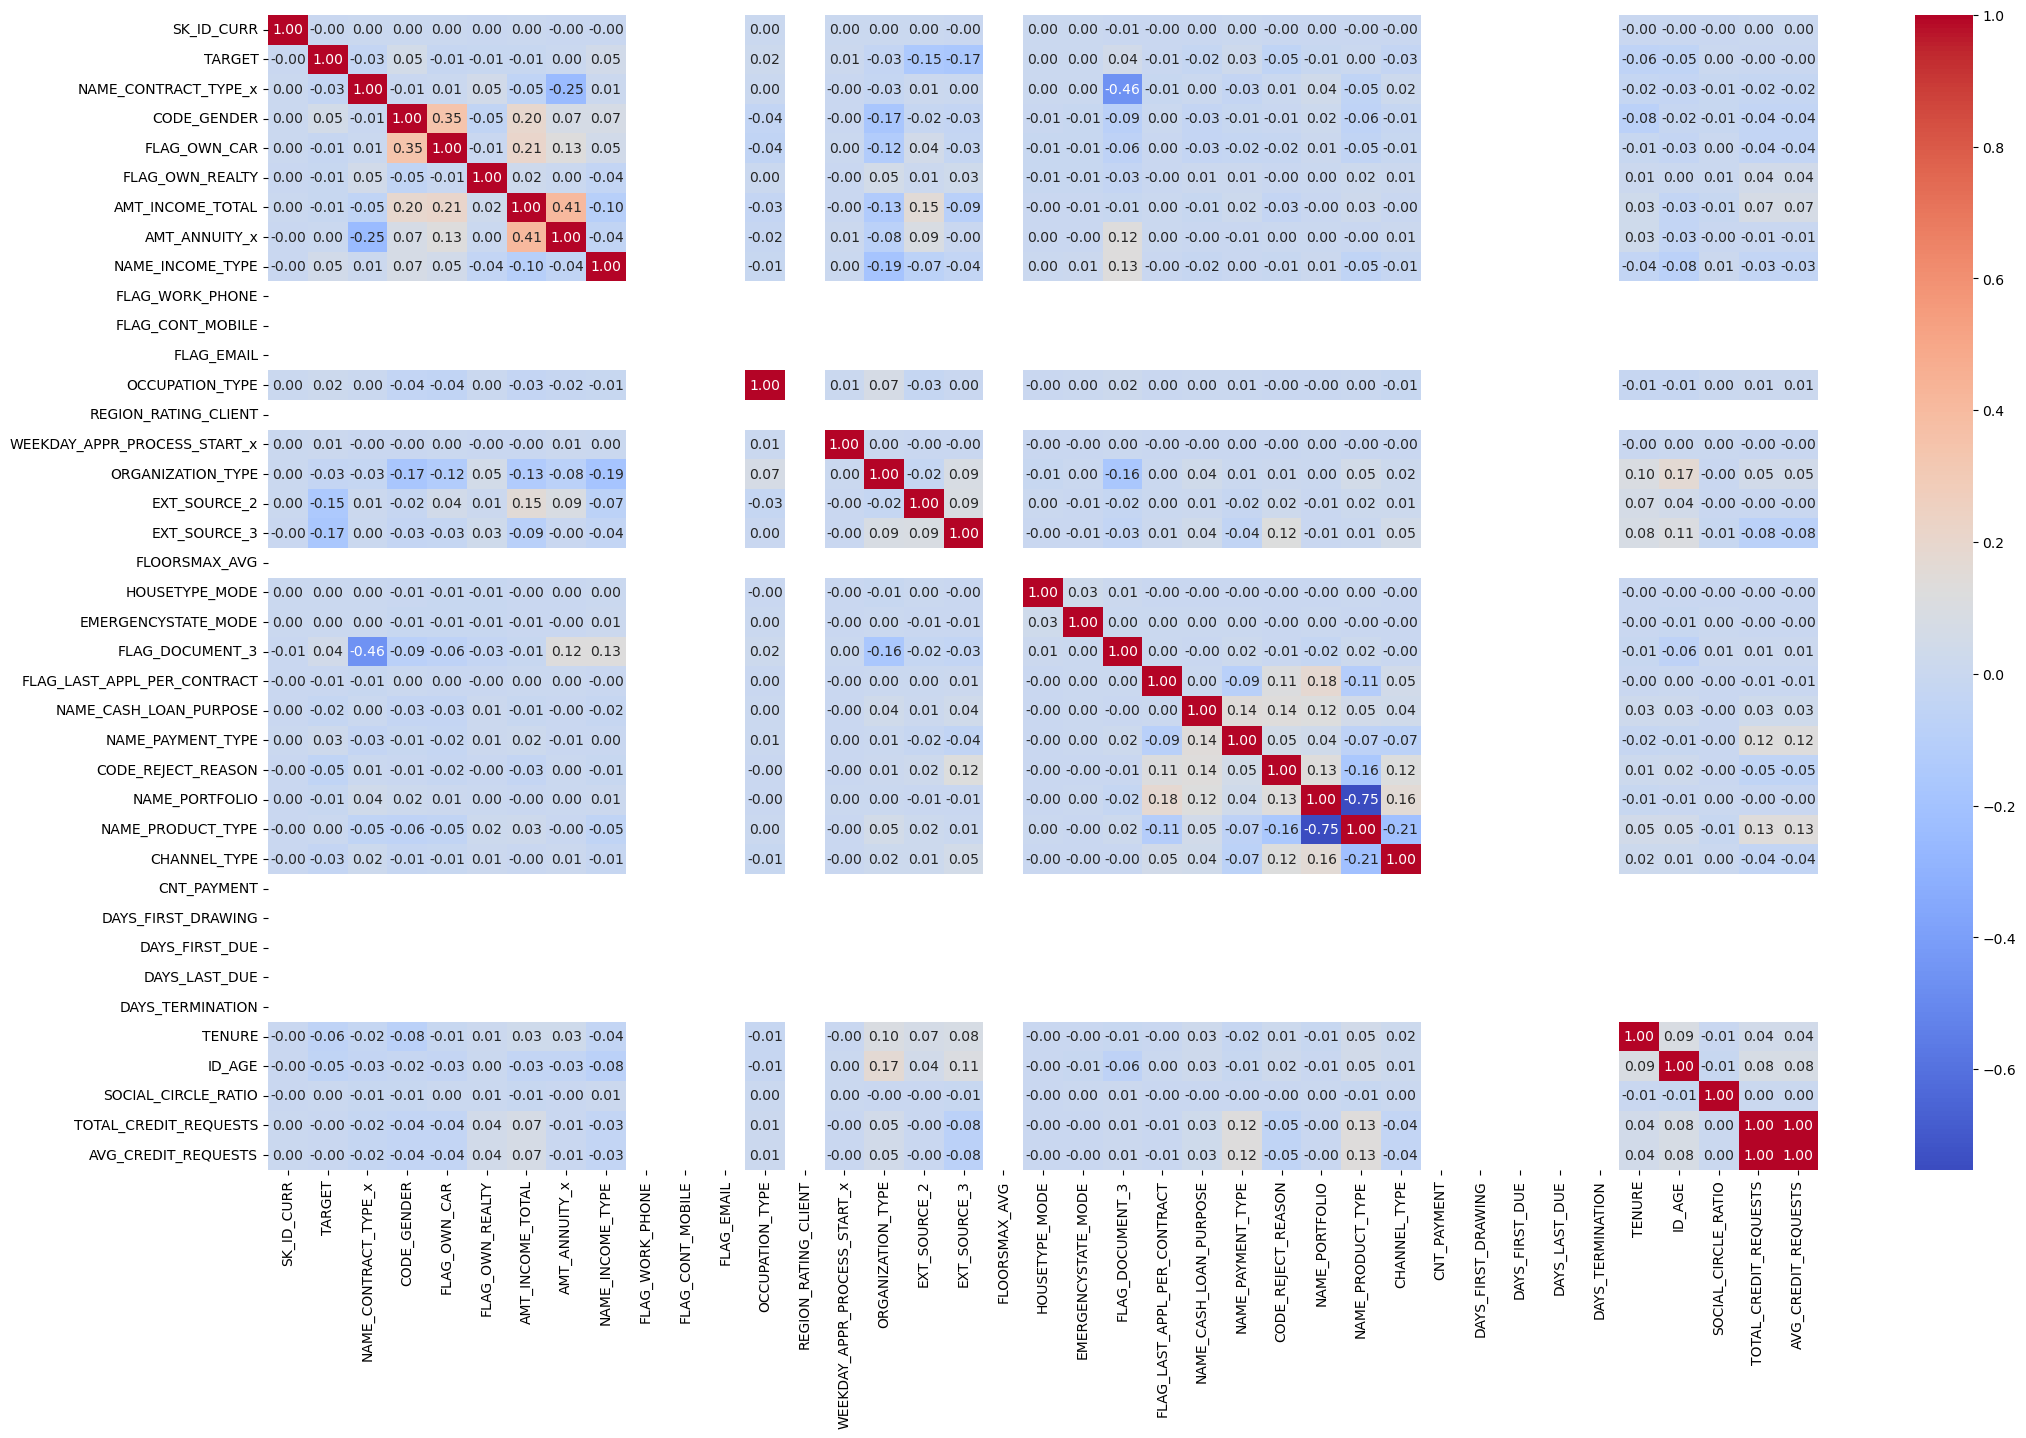

In [57]:
# Compute the correlation matrix
data_1 = data_corrected.corr()

# Create the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(data_1, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


In [61]:
# List of columns to drop
columns_to_drop = [
    'AMT_INCOME_TOTAL','NAME_PORTFOLIO','TOTAL_CREDIT_REQUESTS']

# Drop the columns inplace in the data_corrected DataFrame
data_corrected.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows to verify the columns have been dropped
data_corrected.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_ANNUITY_x,NAME_INCOME_TYPE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,CHANNEL_TYPE,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_TERMINATION,TENURE,ID_AGE,SOCIAL_CIRCLE_RATIO,AVG_CREDIT_REQUESTS
0,100002,1,0,1,0,1,24700.5,6,0.0,1.0,...,7,12.0,365243.0,-825.0,-534.0,-494.0,1.745205,5.808219,0.666667,0.2
1,100003,0,0,0,0,0,35698.5,3,0.0,1.0,...,5,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0
2,100003,0,0,0,0,0,35698.5,3,0.0,1.0,...,7,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0
3,100003,0,0,0,0,0,35698.5,3,0.0,1.0,...,4,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0
4,100004,0,1,1,1,1,6750.0,6,0.0,1.0,...,6,12.0,365243.0,-825.0,-534.0,-494.0,0.616438,6.934247,0.000000,0.0


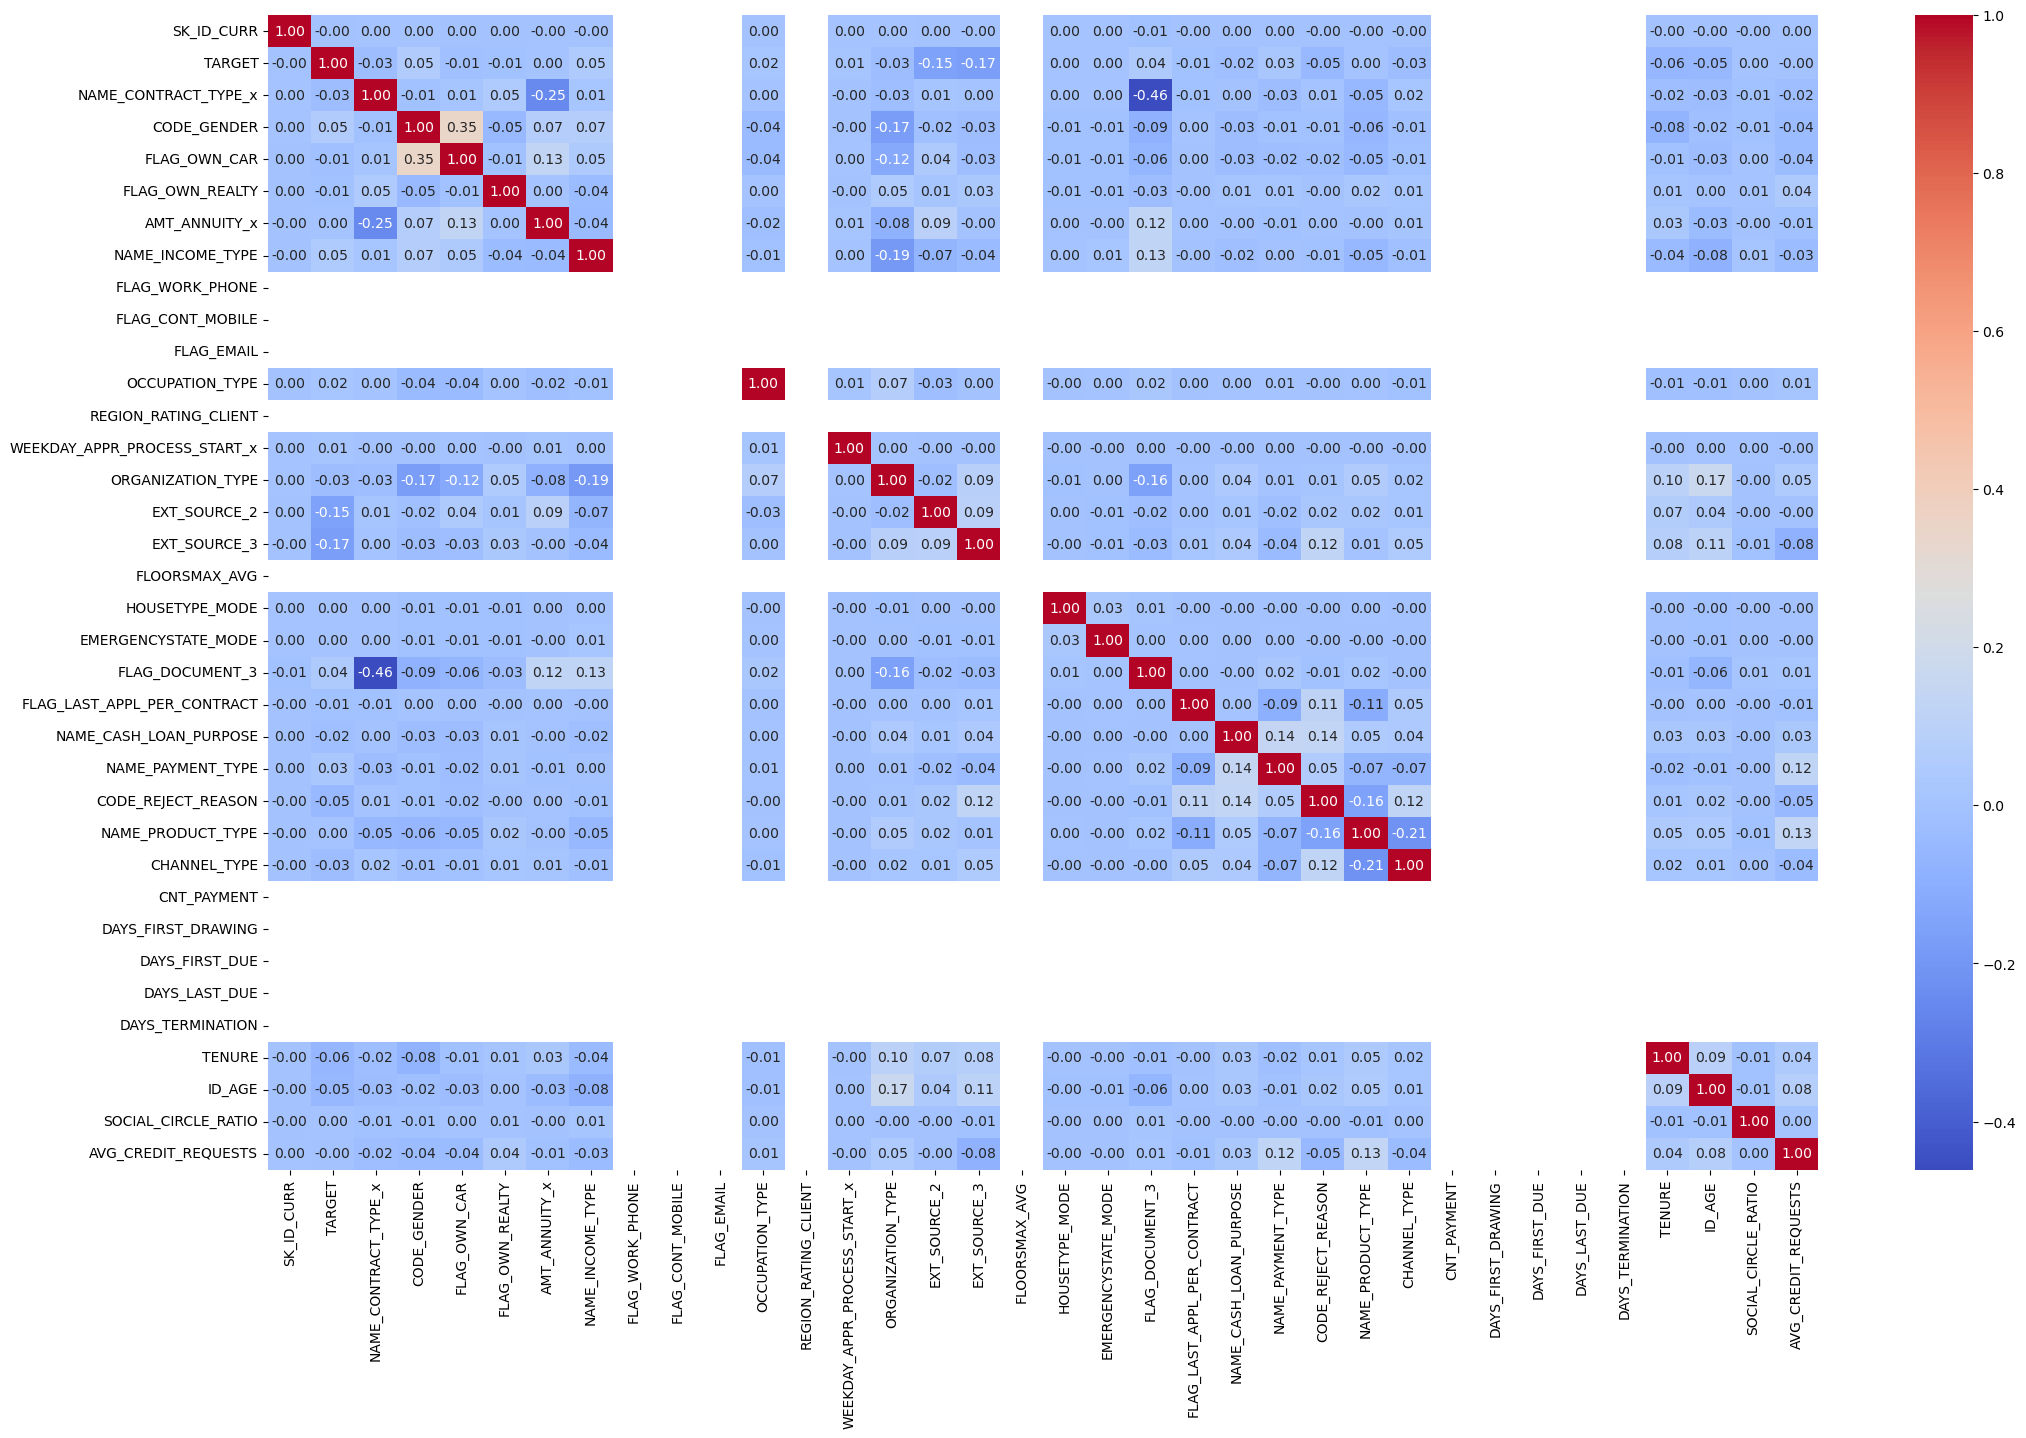

In [63]:
# Compute the correlation matrix
data_1 = data_corrected.corr()

# Create the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(data_1, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [65]:
# List of columns to drop
columns_to_drop = [
    'NAME_CONTRACT_TYPE_x']

# Drop the columns inplace in the data_corrected DataFrame
data_corrected.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows to verify the columns have been dropped
data_corrected.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_ANNUITY_x,NAME_INCOME_TYPE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_EMAIL,...,CHANNEL_TYPE,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,DAYS_TERMINATION,TENURE,ID_AGE,SOCIAL_CIRCLE_RATIO,AVG_CREDIT_REQUESTS
0,100002,1,1,0,1,24700.5,6,0.0,1.0,0.0,...,7,12.0,365243.0,-825.0,-534.0,-494.0,1.745205,5.808219,0.666667,0.2
1,100003,0,0,0,0,35698.5,3,0.0,1.0,0.0,...,5,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0
2,100003,0,0,0,0,35698.5,3,0.0,1.0,0.0,...,7,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0
3,100003,0,0,0,0,35698.5,3,0.0,1.0,0.0,...,4,12.0,365243.0,-825.0,-534.0,-494.0,3.254795,0.797260,1.000000,0.0
4,100004,0,1,1,1,6750.0,6,0.0,1.0,0.0,...,6,12.0,365243.0,-825.0,-534.0,-494.0,0.616438,6.934247,0.000000,0.0


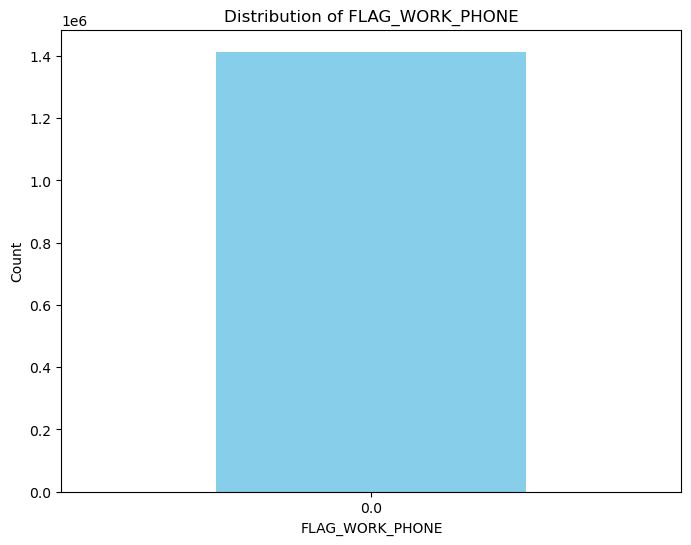

In [71]:
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in the column
value_counts = data_corrected['FLAG_WORK_PHONE'].value_counts()

# Create a bar plot for the counts
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of FLAG_WORK_PHONE')
plt.xlabel('FLAG_WORK_PHONE')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [73]:
data_corrected.shape

(1413701, 35)

In [75]:
# List of columns to drop
columns_to_drop = [
    'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT',
    'FLOORSMAX_AVG', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
    'DAYS_LAST_DUE', 'DAYS_TERMINATION'
]

# Drop the columns inplace in the data_corrected DataFrame
data_corrected.drop(columns=columns_to_drop, inplace=True)

# Display the first few rows to verify the columns have been dropped
data_corrected.head()


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_ANNUITY_x,NAME_INCOME_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START_x,ORGANIZATION_TYPE,...,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_PRODUCT_TYPE,CHANNEL_TYPE,TENURE,ID_AGE,SOCIAL_CIRCLE_RATIO,AVG_CREDIT_REQUESTS
0,100002,1,1,0,1,24700.5,6,8,6,5,...,1,23,3,7,0,7,1.745205,5.808219,0.666667,0.2
1,100003,0,0,0,0,35698.5,3,3,1,39,...,1,24,3,7,2,5,3.254795,0.797260,1.000000,0.0
2,100003,0,0,0,0,35698.5,3,3,1,39,...,1,23,0,7,0,7,3.254795,0.797260,1.000000,0.0
3,100003,0,0,0,0,35698.5,3,3,1,39,...,1,23,0,7,0,4,3.254795,0.797260,1.000000,0.0
4,100004,0,1,1,1,6750.0,6,8,1,11,...,1,23,0,7,0,6,0.616438,6.934247,0.000000,0.0


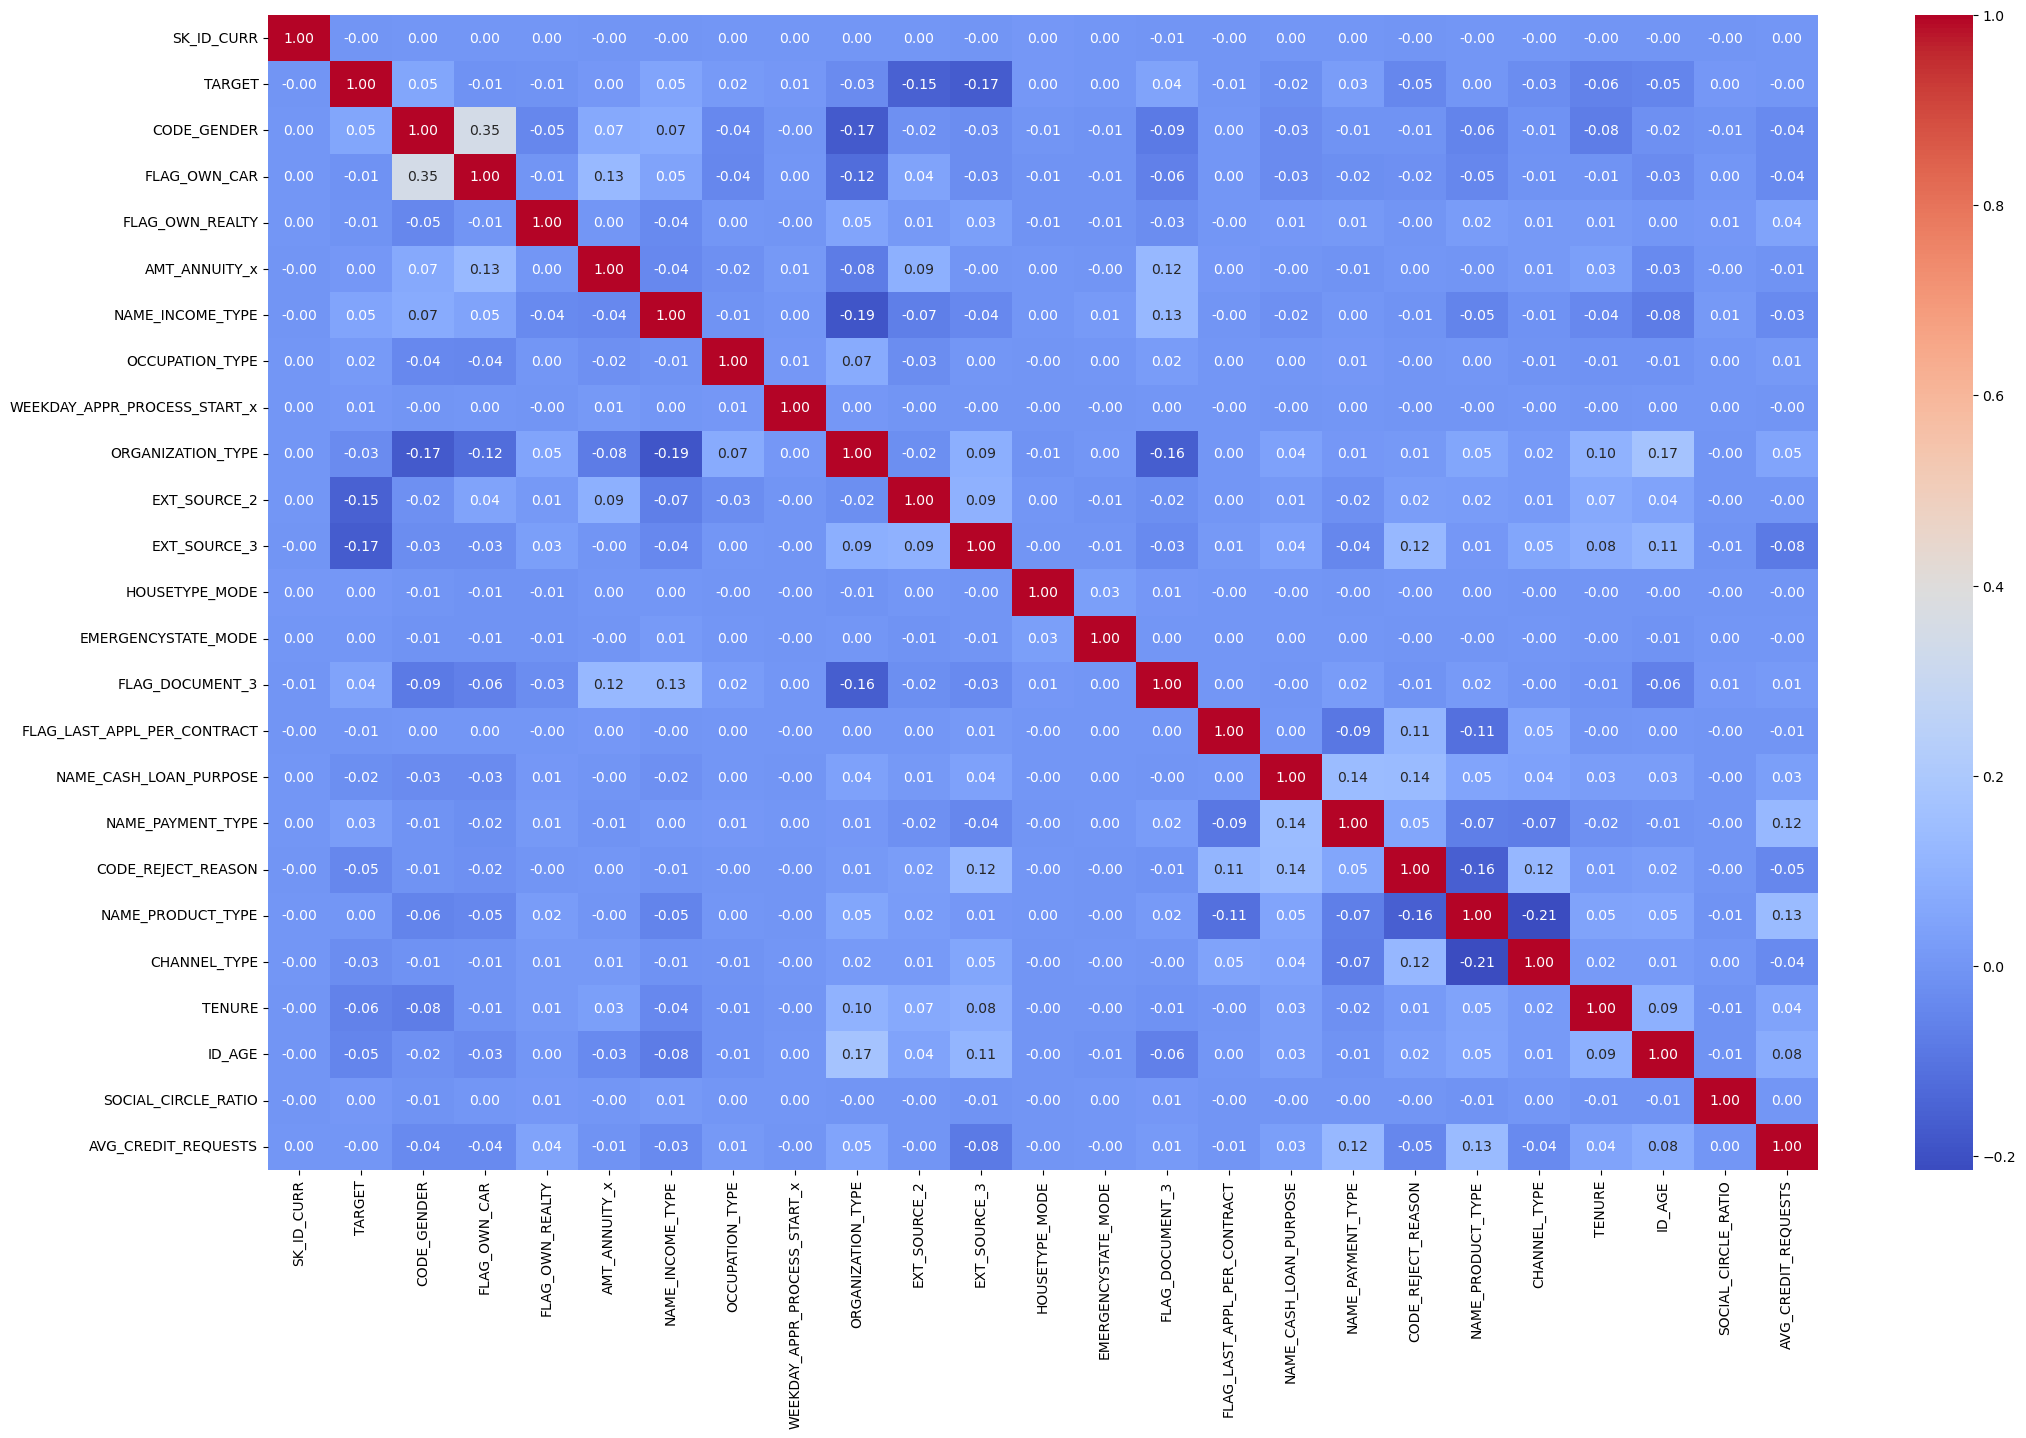

In [77]:
# Compute the correlation matrix
data_1 = data_corrected.corr()

# Create the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(data_1, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [83]:
# saving the final file
output_path ="final_data.csv"
data_corrected.to_csv(output_path, index=False)

In [85]:
data_corrected.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_ANNUITY_x,NAME_INCOME_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START_x,ORGANIZATION_TYPE,...,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_PRODUCT_TYPE,CHANNEL_TYPE,TENURE,ID_AGE,SOCIAL_CIRCLE_RATIO,AVG_CREDIT_REQUESTS
0,100002,1,1,0,1,24700.5,6,8,6,5,...,1,23,3,7,0,7,1.745205,5.808219,0.666667,0.2
1,100003,0,0,0,0,35698.5,3,3,1,39,...,1,24,3,7,2,5,3.254795,0.797260,1.000000,0.0
2,100003,0,0,0,0,35698.5,3,3,1,39,...,1,23,0,7,0,7,3.254795,0.797260,1.000000,0.0
3,100003,0,0,0,0,35698.5,3,3,1,39,...,1,23,0,7,0,4,3.254795,0.797260,1.000000,0.0
4,100004,0,1,1,1,6750.0,6,8,1,11,...,1,23,0,7,0,6,0.616438,6.934247,0.000000,0.0


In [87]:
data_corrected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413701 entries, 0 to 1413700
Data columns (total 25 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1413701 non-null  int64  
 1   TARGET                        1413701 non-null  int64  
 2   CODE_GENDER                   1413701 non-null  int64  
 3   FLAG_OWN_CAR                  1413701 non-null  int64  
 4   FLAG_OWN_REALTY               1413701 non-null  int64  
 5   AMT_ANNUITY_x                 1413701 non-null  float64
 6   NAME_INCOME_TYPE              1413701 non-null  int64  
 7   OCCUPATION_TYPE               1413701 non-null  int64  
 8   WEEKDAY_APPR_PROCESS_START_x  1413701 non-null  int64  
 9   ORGANIZATION_TYPE             1413701 non-null  int64  
 10  EXT_SOURCE_2                  1413701 non-null  float64
 11  EXT_SOURCE_3                  1413701 non-null  float64
 12  HOUSETYPE_MODE              

# SPLIT TRAIN-TEST DATA

In [95]:
#Splitting dependent and independent features

X= data_corrected.drop("TARGET",axis=1)
y= data_corrected["TARGET"]

In [97]:
X.shape

(1413701, 24)

In [99]:
y.shape

(1413701,)

In [101]:
fs = RandomForestClassifier()

In [103]:
fs.fit(X,y)

RandomForestClassifier()

In [105]:
fs.feature_importances_

array([0.11204635, 0.00756006, 0.01142005, 0.01499488, 0.10875726,
       0.01278471, 0.04066933, 0.04680972, 0.05553371, 0.13846127,
       0.11920823, 0.00289365, 0.00212327, 0.00840017, 0.00059362,
       0.01006782, 0.00542765, 0.00855025, 0.00712962, 0.01764048,
       0.07881302, 0.1126334 , 0.02847214, 0.04900933])

In [107]:
fs_score = pd.DataFrame({
    "columns":X.columns,
    "score":fs.feature_importances_
}).sort_values("score",ascending=False)

In [109]:
fs_score

,columns,score
9,EXT_SOURCE_2,0.138461
10,EXT_SOURCE_3,0.119208
21,ID_AGE,0.112633
0,SK_ID_CURR,0.112046
4,AMT_ANNUITY_x,0.108757
20,TENURE,0.078813
8,ORGANIZATION_TYPE,0.055534
23,AVG_CREDIT_REQUESTS,0.049009
7,WEEKDAY_APPR_PROCESS_START_x,0.046810
6,OCCUPATION_TYPE,0.040669


In [111]:
selected_features=list(fs_score.sort_values("score",ascending=False).head(15)["columns"].values)

In [113]:
X1 =X[selected_features]

In [115]:
X1.columns

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'ID_AGE', 'SK_ID_CURR', 'AMT_ANNUITY_x',
       'TENURE', 'ORGANIZATION_TYPE', 'AVG_CREDIT_REQUESTS',
       'WEEKDAY_APPR_PROCESS_START_x', 'OCCUPATION_TYPE',
       'SOCIAL_CIRCLE_RATIO', 'CHANNEL_TYPE', 'FLAG_OWN_REALTY',
       'NAME_INCOME_TYPE', 'FLAG_OWN_CAR'],
      dtype='object')

In [117]:
X1.shape    

(1413701, 15)

In [119]:
y.value_counts()

TARGET
0    1291341
1     122360
Name: count, dtype: int64

# SMOTE

In [121]:
# Doing over sampling to balance the data

smote=SMOTE()
X2,y1 = smote.fit_resample(X1,y)

In [123]:
y1.value_counts()

TARGET
1    1291341
0    1291341
Name: count, dtype: int64

In [126]:
X2.head()

,EXT_SOURCE_2,EXT_SOURCE_3,ID_AGE,SK_ID_CURR,AMT_ANNUITY_x,TENURE,ORGANIZATION_TYPE,AVG_CREDIT_REQUESTS,WEEKDAY_APPR_PROCESS_START_x,OCCUPATION_TYPE,SOCIAL_CIRCLE_RATIO,CHANNEL_TYPE,FLAG_OWN_REALTY,NAME_INCOME_TYPE,FLAG_OWN_CAR
0,0.262949,0.139376,5.808219,100002,24700.5,1.745205,5,0.2,6,8,0.666667,7,1,6,0
1,0.622246,0.510090,0.797260,100003,35698.5,3.254795,39,0.0,1,3,1.000000,5,0,3,0
2,0.622246,0.510090,0.797260,100003,35698.5,3.254795,39,0.0,1,3,1.000000,7,0,3,0
3,0.622246,0.510090,0.797260,100003,35698.5,3.254795,39,0.0,1,3,1.000000,4,0,3,0
4,0.555912,0.729567,6.934247,100004,6750.0,0.616438,11,0.0,1,8,0.000000,6,1,6,1


# SPLIT--------->

In [129]:
# train test split
X2_train,X2_test,y1_train,y1_test = train_test_split(X2,y1,test_size=0.2,random_state=54)

In [131]:
X2_train.shape

(2066145, 15)

In [133]:
X2_test.shape

(516537, 15)

# MODEL BUILDING

# 1. DECISION TREE

In [140]:

dt = DecisionTreeClassifier(max_depth=4,random_state=54)

In [142]:
dt.fit(X2_train,y1_train)

DecisionTreeClassifier(max_depth=4, random_state=54)

In [144]:
dttrain_predict =dt.predict(X2_train)
dttest_predict =dt.predict(X2_test)

In [146]:
def metrics(actual,predicted):
    print("accuracy:",round(accuracy_score(actual,predicted)*100,2))
    print("precision:",round(precision_score(actual,predicted)*100,2))
    print("recall:",round(recall_score(actual,predicted)*100,2))
    print("f1:",round(f1_score(actual,predicted)*100,2))
    print("roc_curve:",round(roc_auc_score(actual,predicted)*100,2))
    print("classification",confusion_matrix(actual,predicted))

In [148]:
metrics(y1_train,dttrain_predict)
metrics(y1_test,dttest_predict)

accuracy: 65.84
precision: 66.92
recall: 62.66
f1: 64.72
roc_curve: 65.84
classification [[713206 319954]
 [385739 647246]]
accuracy: 65.87
precision: 66.98
recall: 62.66
f1: 64.75
roc_curve: 65.87
classification [[178356  79825]
 [ 96470 161886]]


# 2.RAMDOM FOREST

In [176]:
rf = RandomForestClassifier(n_estimators=500,random_state=54,max_depth=5)

In [178]:
rf.fit(X2_train,y1_train)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=54)

In [180]:
rftrain_predict = rf.predict(X2_train)
rftest_predict =rf.predict(X2_test)

In [182]:
metrics(y1_train,rftrain_predict)
metrics(y1_test,rftest_predict)

accuracy: 68.33
precision: 67.94
recall: 69.39
f1: 68.66
roc_curve: 68.33
classification [[694974 338186]
 [316179 716806]]
accuracy: 68.32
precision: 67.97
recall: 69.34
f1: 68.65
roc_curve: 68.32
classification [[173769  84412]
 [ 79220 179136]]


# GRADIENT BOOST

In [160]:
gb =GradientBoostingClassifier(n_estimators=700,random_state=54)

In [162]:
gb.fit(X2_train,y1_train)

GradientBoostingClassifier(n_estimators=700, random_state=54)

In [164]:
gbtrain_predict =gb.predict(X2_train)
gbtest_predict= gb.predict(X2_test)

In [166]:
metrics(y1_train,gbtrain_predict)
metrics(y1_test,gbtest_predict)

accuracy: 73.42
precision: 74.2
recall: 71.82
f1: 72.99
roc_curve: 73.42
classification [[775197 257963]
 [291129 741856]]
accuracy: 73.33
precision: 74.14
recall: 71.69
f1: 72.89
roc_curve: 73.33
classification [[193574  64607]
 [ 73142 185214]]


# EXTREME GRAIDENT BOOSTING

In [168]:
xg = xgb.XGBClassifier(n_estimators=1500,random_state=54,learning_rate=0.17,
                       max_depth=7,min_child_weight=3)

In [170]:
xg.fit(X2_train,y1_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, random_state=54, ...)

In [172]:
xgtrain_predict =xg.predict(X2_train)
xgtest_predict= xg.predict(X2_test)


In [174]:
metrics(y1_train,xgtrain_predict)
metrics(y1_test,xgtest_predict)

accuracy: 98.18
precision: 98.65
recall: 97.69
f1: 98.17
roc_curve: 98.18
classification [[1019332   13828]
 [  23849 1009136]]
accuracy: 97.72
precision: 98.19
recall: 97.24
f1: 97.71
roc_curve: 97.72
classification [[253552   4629]
 [  7140 251216]]


In [184]:


# Specify the path where the model should be saved
model_path = r"D:\Final-Project\xg.pkl"

# Save the model to the specified path
with open(model_path, "wb") as file:
    pkl.dump(xg, file)

print(f"Model saved to {model_path}")



Model saved to D:\Final-Project\xg.pkl


Confusion Matrix:
[[253552   4629]
 [  7140 251216]]


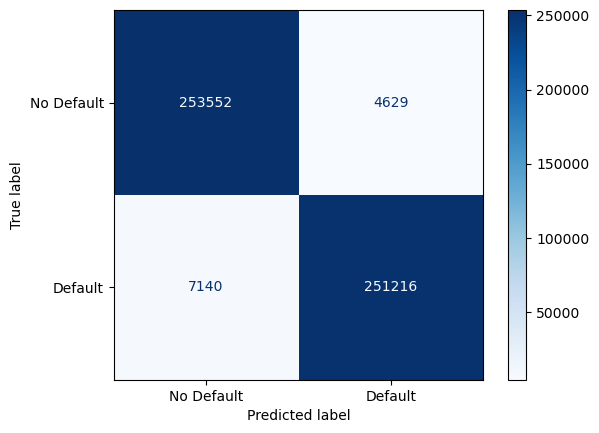

In [188]:
import pickle as pkl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the saved model from the specified path
model_path = r"D:\Final-Project\xg.pkl"
with open(model_path, "rb") as file:
    loaded_model = pkl.load(file)

# Predict on the test data using the loaded model
test_predictions = loaded_model.predict(X2_test)

# Generate the confusion matrix
cm = confusion_matrix(y1_test, test_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Default", "Default"])
disp.plot(cmap="Blues", values_format="d")

print("Confusion Matrix:")
print(cm)

